In [1]:
from __future__ import annotations

import pathlib
from datetime import datetime

import polars
from matplotlib import pyplot as plt

_ = polars.Config.set_tbl_rows(100)

In [2]:
data_file = '../data/mcq/mcq.log'

In [3]:
def load_events(log: pathlib.Path) -> polars.DataFrame:
    event_lines = []

    with open(log) as f:
        for line in f:
            if 'TIMEINFO' in line:
                event_lines.append(line)

    events = []
    for line in event_lines:
        data = {}
        sl = line.split(' ')
        data['timestamp'] = datetime.strptime(
            ' '.join(sl[0:2])[1:-1],  # first 2 elements without [ ]
            '%Y-%m-%d %H:%M:%S.%f',
        )
        # trim name
        task_id = sl[-1].strip()
        name = sl[7].split('-')[0]
        if 'mistralai' in sl[7] and 'llama' in sl[7]:
            if 'mistralai' in sl[7].split(':')[1]:
                name = f'{name}A'
            if 'llama' in sl[7].split(':')[1]:
                name = f'{name}B'
        elif 'mistralai' in sl[7]:
            name = f'{name}A'
        elif 'llama' in sl[7]:
            name = f'{name}B'
        data['task'] = name
        data['task_id'] = task_id
        data['event_type'] = sl[9].strip()
        events.append(data)

    paired_events = []

    while len(events) > 0:
        ev = events.pop(0)
        if ev['event_type'] == 'start':
            for e in events:
                if e['event_type'] == 'end':
                    if ev['task_id'] == e['task_id']:
                        ev['start'] = ev['timestamp']
                        ev['end'] = e['timestamp']
                        paired_events.append(ev)

    df = polars.from_dicts(paired_events)
    df = (
        df.with_columns(
            [
                (
                    (
                        polars.col('timestamp') - polars.col('timestamp').min()
                    ).dt.total_milliseconds()
                    / 1000
                ).alias('timestamp'),
            ],
        )
        .sort('timestamp')
        .with_columns(
            (
                (
                    polars.col('end') - polars.col('start')
                ).dt.total_milliseconds()
                / 1000
                # .clip(0)
            ).alias('duration'),
        )
    )

    return df


df = load_events(data_file)

In [4]:
df

timestamp,task,task_id,event_type,start,end,duration
f64,str,str,str,datetime[μs],datetime[μs],f64
0.0,"""PDFParser""","""eb29ba69""","""start""",2025-04-11 21:28:03.222,2025-04-11 21:28:03.563,0.341
0.344,"""PDFParser""","""d7adf96a""","""start""",2025-04-11 21:28:03.566,2025-04-11 21:28:04.242,0.676
1.022,"""PDFParser""","""f7229f46""","""start""",2025-04-11 21:28:04.244,2025-04-11 21:28:05.991,1.747
2.772,"""PDFParser""","""1c48c32e""","""start""",2025-04-11 21:28:05.994,2025-04-11 21:28:06.500,0.506
3.28,"""PDFParser""","""b0ca9c28""","""start""",2025-04-11 21:28:06.502,2025-04-11 21:28:06.922,0.42
3.701,"""PDFParser""","""054fff4f""","""start""",2025-04-11 21:28:06.923,2025-04-11 21:28:07.293,0.37
4.073,"""PDFParser""","""b09fe6ff""","""start""",2025-04-11 21:28:07.295,2025-04-11 21:28:07.997,0.702
4.777,"""PDFParser""","""3e7dcc0c""","""start""",2025-04-11 21:28:07.999,2025-04-11 21:28:08.642,0.643
5.421,"""PDFParser""","""ef757ad9""","""start""",2025-04-11 21:28:08.643,2025-04-11 21:28:12.326,3.683


In [9]:
def plot_gantt(
    raw,
    partitioned_events,
    label_spaces,
    max_x,
    max_y,
    counts=True,
) -> None:
    fig, axs = plt.subplots(1, 1)

    colors = {
        'PDFParser': '#3969AC',
        'MCQGeneratorA': '#D0C2F4',
        'MCQGeneratorB': '#4D3886',
        'MCQSelector': '#E68310',
        'MCQAnswererA': '#B8E4D7',
        'MCQAnswererB': '#11A579',
        'AnswerScorerA': '#F0BCC9',
        'AnswerScorerB': '#D64269',
    }

    label_index = {}
    sep_bars = []
    next_index = 0
    for task in partitioned_events:
        # for worker in partitioned_events[task]:
        label_index[task] = next_index
        if task in ['MCQGeneratorA', 'MCQGeneratorB']:
            next_index += len(partitioned_events[task])
        else:
            next_index += 1
        # Add space and bar between types
        if task in [
            'PDFParser',
            'MCQGeneratorA',
            'MCQGeneratorB',
            'MCQSelector',
            'MCQAnswererB',
        ]:
            sep_bars.append(next_index)
            next_index += 1
        # Add only space between types
        elif task in ['MCQAnswererA', 'AnswerScorerA']:
            next_index += 1

    for task in partitioned_events:
        for i, events in enumerate(partitioned_events[task]):
            if 'Generator' in task:
                index = label_index[task] + i
            else:
                index = label_index[task]

            if events[1] == 0:
                # Make the selector visible
                axs.broken_barh(
                    [(events[0], 1)],
                    (index, 0.75),
                    facecolor=colors[task],
                    label=task,
                )
            else:
                axs.broken_barh(
                    [events],
                    (index, 0.75),
                    facecolor=colors[task],
                    label=task,
                )

    for y in sep_bars:
        axs.axhline(y + 0.5, xmin=0, xmax=max_x, linewidth=0.5, color='black')

    axs.grid(False)
    axs.grid(which='major', axis='x')
    axs.set_axisbelow(True)
    axs.set(ylim=[-0.5, max_y + 0.5], xlim=[0, max_x], xlabel='Runtime (s)')

    axs.set_yticks(
        label_spaces,
        labels=[
            'PDFParser',
            'MCQGeneratorA',
            'MCQGeneratorB',
            'MCQSelector',
            'MCQAnswererA',
            'MCQAnswererB',
            'AnswerScorerA',
            'AnswerScorerB',
        ],
    )
    axs.tick_params('y', length=0, width=0, which='major')

    fig.tight_layout()
    plt.draw()
    fig.set_size_inches(3.5, 1.2)
    fig.savefig('figures/mcq-small.pdf')

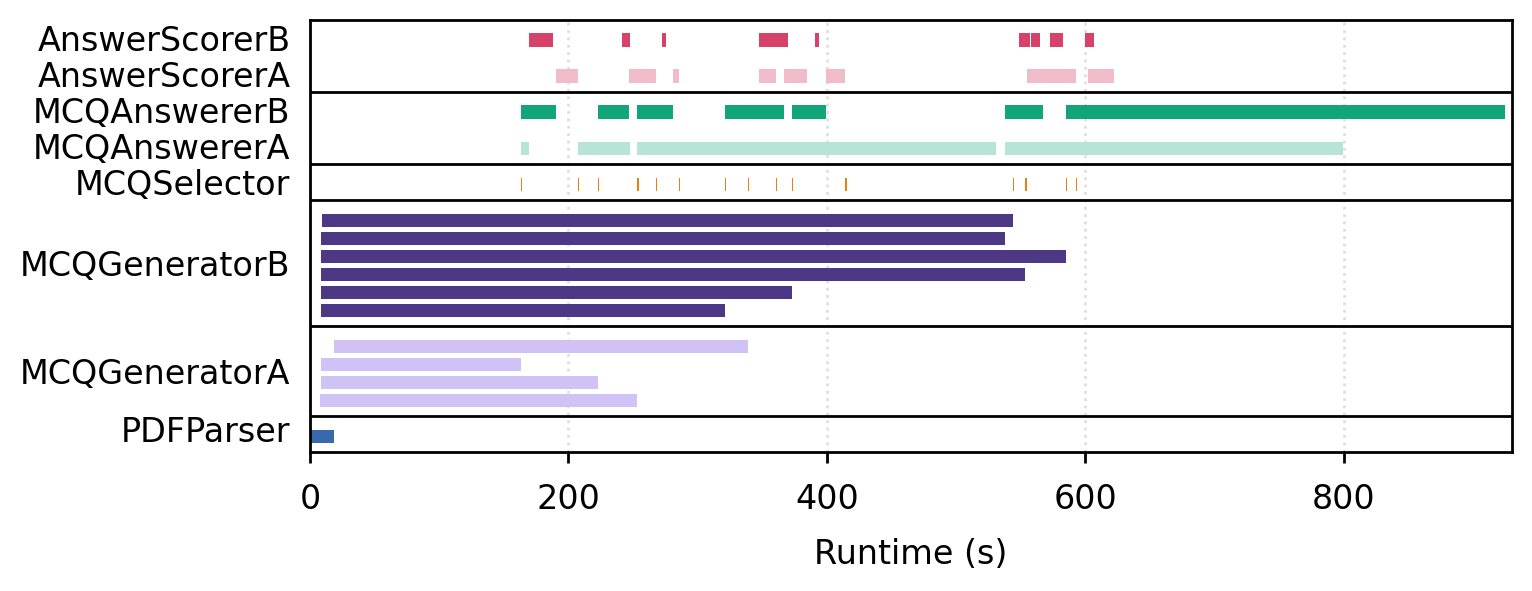

In [10]:
task_names = [
    'PDFParser',
    'MCQGeneratorA',
    'MCQGeneratorB',
    'MCQSelector',
    'MCQAnswererA',
    'MCQAnswererB',
    'AnswerScorerA',
    'AnswerScorerB',
]


def load_and_plot(
    stacked=False,
    counts=True,
):
    raw = load_events(data_file)
    task_events = {
        name: raw.filter(polars.col('task') == name)
        .select('timestamp', 'duration')
        .rows()
        for name in task_names
    }

    plot_gantt(
        raw,
        task_events,
        label_spaces=[0.8, 4, 10, 14.5, 16.5, 18.5, 20.5, 22.5],
        max_y=23,
        max_x=930,
    )


load_and_plot()